In [263]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.ipc import *
from utils.util import *

In [264]:
N = 1000
g = 1.
noise_std = 0.3
input_intensity = 1.
max_leadout = 50
degree_list = [1,2,3,4,5]#[1,3,5,7,9]
Tobs = int(1e5) #観測時間
Tinit = int(1e4) #washout時間
act_func =  lambda x: np.maximum(0,x) #ReLU
trial = 10

In [265]:
# 条件付き最大リアプノフ指数
T_sim = 10**4
Ton = 10 #摂動を加える時間間隔
eps = 1e-3 #摂動の大きさ
le_trial = 10

LE_trial = np.zeros(le_trial)
for j in tqdm(range(le_trial)):
    J = np.random.normal(0,g/np.sqrt(N),[N,N])
    win = np.random.normal(0,1,N)*input_intensity
    
    x1 = np.zeros([N,T_sim])
    x2 = np.zeros([N,T_sim])
    x1[:,0] = np.random.normal(0,1,N)

    # 初期状態の影響をなくす
    for i in range(10**3):
        x1[:,0] = J@act_func(x1[:,0])+np.random.normal(0,1)*win + np.random.normal(0,noise_std,N)


    x2[:,0] = x1[:,0].copy() + np.random.normal(0,1, N)

    ratio = []
    # 時間発展
    for i in range(T_sim-1):
        if i%Ton == 0:
            perturbation = x2[:,i] - x1[:,i]
            perturbation = perturbation * eps/np.sqrt(np.mean(perturbation**2))
            x2[:,i] = x1[:,i] + perturbation
        indata = np.random.normal(0,1)
        noise = np.random.normal(0,noise_std,N)
        x1[:,i+1] = J@act_func(x1[:,i])+indata*win + noise
        x2[:,i+1] = J@act_func(x2[:,i])+indata*win + noise
        if i%Ton == Ton-1:
            delta = x1[:,i+1]-x2[:,i+1]
            growth_rate = np.mean(delta**2)/(eps**2)
            ratio.append(growth_rate)

    ratio = np.array(ratio)
    LE_trial[j] =  0.5*np.mean(np.log(ratio+1e-9)/Ton)

LE_mean = np.mean(LE_trial)
LE_std = np.std(LE_trial)
print("mean:{0}, std:{1}".format(LE_mean, LE_std))

100%|██████████| 10/10 [00:17<00:00,  1.78s/it]

mean:-0.34594002442807703, std:0.008369253290433663


In [266]:
#　ニューロン相関の強さ
cor = cor_calc(g,N,act_func, sigma=input_intensity, sigma_noise=noise_std, trial=10, Tobs= 10000, Tinit=1000, device="cpu")
print(cor)

0.37683398


In [267]:
# 活動の大きさ
activity_scale = np.sqrt(np.mean(x1**2))
print(activity_scale)

1.5158093228143747


In [268]:
ipc_list = np.zeros([trial, max_leadout, len(degree_list)])

for i in range(trial):  
    ipc = calc_ipc(N,g,input_intensity,max_leadout,degree_list,Tobs,Tinit,act_func,noise_std=noise_std)
    ipc_list[i,:,:] = ipc.copy()
    print(f"trial {i+1}/{trial} was done")

100%|██████████| 50/50 [00:32<00:00,  1.52it/s]


trial 1/10 was done


100%|██████████| 50/50 [00:31<00:00,  1.60it/s]


trial 2/10 was done


100%|██████████| 50/50 [00:30<00:00,  1.63it/s]


trial 3/10 was done


100%|██████████| 50/50 [00:29<00:00,  1.71it/s]


trial 4/10 was done


100%|██████████| 50/50 [00:30<00:00,  1.66it/s]


trial 5/10 was done


100%|██████████| 50/50 [00:31<00:00,  1.58it/s]


trial 6/10 was done


100%|██████████| 50/50 [00:30<00:00,  1.63it/s]


trial 7/10 was done


100%|██████████| 50/50 [00:32<00:00,  1.56it/s]


trial 8/10 was done


100%|██████████| 50/50 [00:28<00:00,  1.78it/s]


trial 9/10 was done


100%|██████████| 50/50 [00:31<00:00,  1.59it/s]

trial 10/10 was done


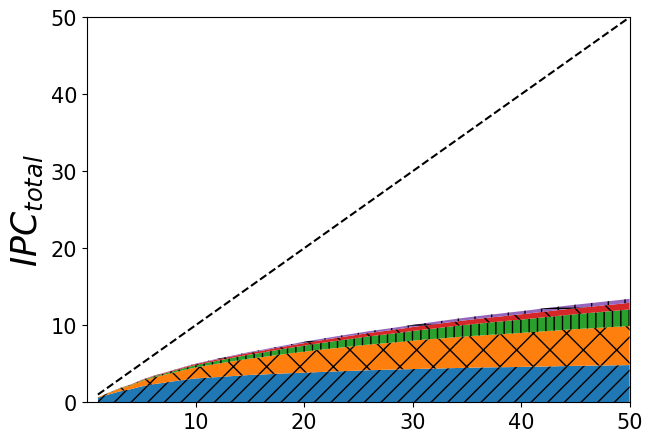

In [269]:
fig = plt.figure(figsize=(7,5))
hatch_list  = ['//', 'x', '||', '\\', "+", "..", "xx"]

bottom = np.zeros([max_leadout])
upper = np.mean(ipc_list[:,:,0], axis=0)

for i in range(1, len(degree_list)+1):
    plt.fill_between(np.arange(1,max_leadout+1), bottom, upper, label=f"D={degree_list[i-1]}", hatch=hatch_list[i-1])
    bottom += np.mean(ipc_list[:,:,i-1], axis=0)
    if i<len(degree_list):
        upper += np.mean(ipc_list[:,:,i], axis=0)
plt.plot(np.arange(1,max_leadout+1),np.arange(1,max_leadout+1), color="black",linestyle="--")
plt.xticks([10,20, 30, 40, 50])
#plt.xlabel(r"$L$",fontsize=16)
plt.ylabel(r"$IPC_{total}$",fontsize=25)
plt.tick_params(labelsize=15)
plt.xlim(0,max_leadout)
plt.ylim(0,max_leadout)
#plt.legend(fontsize=18)
plt.savefig("fig/fig6.png")
plt.show()

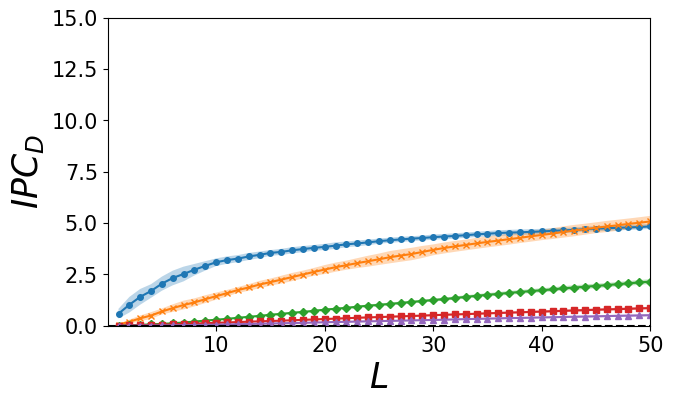

In [270]:
fig = plt.figure(figsize=(7,4))
markers =["o", "x", "D", "s", "^", ">"]
for i in range(0, len(degree_list)):
    plt.plot(np.arange(1,max_leadout+1), np.mean(ipc_list[:,:,i], axis=0), label=f"D={degree_list[i]}", marker=markers[i], markersize=4)
    plt.fill_between(np.arange(1,max_leadout+1), np.mean(ipc_list[:,:,i], axis=0)-np.std(ipc_list[:,:,i], axis=0),\
                                                np.mean(ipc_list[:,:,i], axis=0)+np.std(ipc_list[:,:,i], axis=0), alpha=0.3)
plt.xticks([10,20, 30, 40, 50])
plt.xlabel(r"$L$",fontsize=25)
plt.ylabel(r"$IPC_D$",fontsize=25)
plt.tick_params(labelsize=15)
plt.xlim(0,max_leadout)
plt.ylim(0,15)
plt.axhline(y=0, color="k", linestyle="--")
#plt.legend(fontsize=18)
plt.savefig("fig/fig6_each.png")

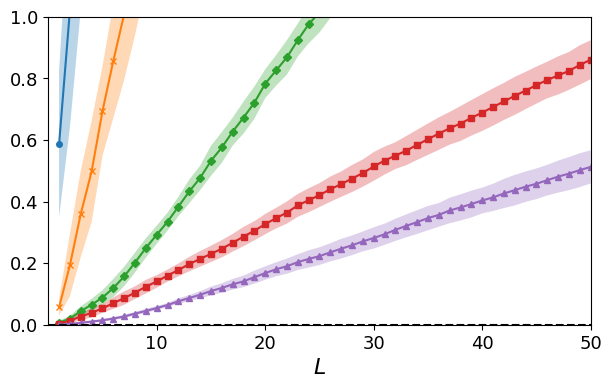

In [271]:
fig = plt.figure(figsize=(7,4))
markers =["o", "x", "D", "s", "^", ">", "."]
for i in range(0, len(degree_list)):
    if i==0:
        label="D=1(memory capacity)"
    else:
        label=f"D={degree_list[i]}"
    plt.plot(np.arange(1,max_leadout+1), np.mean(ipc_list[:,:,i], axis=0), label=label, marker=markers[i], markersize=4)
    plt.fill_between(np.arange(1,max_leadout+1), np.mean(ipc_list[:,:,i], axis=0)-np.std(ipc_list[:,:,i], axis=0),\
                                                np.mean(ipc_list[:,:,i], axis=0)+np.std(ipc_list[:,:,i], axis=0), alpha=0.3)
plt.xticks([10,20, 30, 40, 50])
plt.xlabel(r"$L$",fontsize=16)
#plt.ylabel(r"$IPC_D$",fontsize=16)
plt.tick_params(labelsize=13)
plt.xlim(0,50)
plt.ylim(0,1.)
plt.axhline(y=0, color="k", linestyle="--")
#plt.legend(fontsize=11)
plt.savefig("fig/fig6_each_zoom.png")

In [272]:
np.save(f"data/ipc_g{g}_s{input_intensity}_n{noise_std}", ipc_list)

In [273]:
g

1.0